<a href="https://colab.research.google.com/github/adelfos/_Aaa_ds_advanced/blob/main/6.2%20%D0%9F%D1%80%D0%BE%D0%B4%D0%B2%D0%B8%D0%BD%D1%83%D1%82%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA_%7C_%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81_%D0%BF%D0%BE%D0%B4%D0%BA%D1%80%D0%B5%D0%BF%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%D0%BC_%D0%92%D0%B2%D0%B5%D0%B4%D0%B5%D0%BD%D0%B8%D0%B5_%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_Q_learning_(%D0%BF%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_1)_%7C_%D0%A3%D0%98%D0%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1tIWj21EKDHdmLvlzVISYmrAYbSv1q7OF?usp=sharing&)
2. Практический ноутбук 1
3. [Практический ноутбук 2](https://colab.research.google.com/drive/1ENgfK6-RmUlW5p9_J25wn-XXgh-2TJsw?usp=sharing&)


# Программа визуализации Q-таблицы и процесса обучения алгоритма Q-learning

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

import matplotlib.patches as patches

from IPython.display import clear_output

import time

import seaborn as sns
sns.set_style('darkgrid')

Сначала нам нужно написать код для создания среды, агента, а также правила, по которым агент может взаимодействовать со средой. 

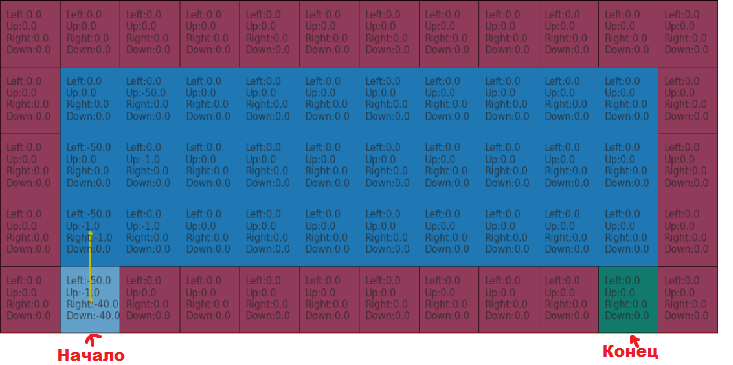

Агент может двигаться с любой синей ячейки влево, вправо, вверх или вниз. Его цель — пройти с начальной ячейки до конечной и при этом не попадать на фиолетовые ячейки. Игра заканчивается выигрышем при попадании на конечную ячейку либо проигрышем при попадании на любую из фиолетовых. Также желательно пройти до финиша кратчайшим путем. Путь, который прошел наш агент, размечается желтой линией.

Эта задача очень простая, а потому здесь немного возможных уникальных состояний. Считайте ее демонстративной: она поможет увидеть суть основного алгоритма Q-learning, не используя нейронных сетей.

В ячейках ниже представлен код для создания среды. В лист `points` соберем награды за ход, назначим -50 очков за попадание в плохую ячейку, -1 за обычный шаг. Последнее нужно, чтобы находить кратчайший путь (хотя и без него тоже можно найти кратчайший путь, но будет сложнее). Также добавим +10 очков, когда агент попадает в финальную ячейку.

In [ ]:
# Назначаем награду: 
points = [-50, -1, 10] 

# Движение влево, вправо, вверх и вниз:
step = ([[-1, 0], [0, 1], [1, 0], [0, -1]]) 

# Коэффициент учета будущих награждений:
kf_rewards = 0.99  

# Параметр случайного хода Epsilon Greedy:
epsilon = 1.0 

# Матрица наград игрового поля (Q-таблица): 
rewards = np.zeros((5,13,4)) 

# Стартовая позиция:
start_position = np.array([1,0]) 

# Финишная позиция:
finish_position = np.array([10,0]) 

# Начальные награды в стартовой точке (инициализируем как -40, чтобы ускорить обучение):
rewards[start_position[1],start_position[0]] = points[0]+10 

In [ ]:
# Функция создания игрового поля

def createField(): 
  
  # Создаем полотно:
  fig, ax = plt.subplots(1, figsize=(24, 10)) 

  # Создаем прямоугольник вокруг всего игрового поля:
  rect = patches.Rectangle((0, 5), 12, -5, linewidth = 2, edgecolor = 'black') 
    
  # Рисуем прямоугольник:
  ax.add_patch(rect) 

  # Создаем прямоугольник стартовой позиции:
  rect = patches.Rectangle((1,1), 1, -1, linewidth = 1, edgecolor = 'black', facecolor = 'white', alpha = 0.3) 
  
  # Рисуем прямоугольник:
  ax.add_patch(rect)         
  
  # Рисуем «опасные» прямоугольники по границе игрового поля:

  for i in range(2,10):
    rect = patches.Rectangle((i,1), 1, -1, linewidth = 1, edgecolor = 'black', facecolor = 'red', alpha = 0.5)
    ax.add_patch(rect)
  
  for i in range(1,12):
    rect = patches.Rectangle((i,5), 1, -1, linewidth = 1, edgecolor = 'black', facecolor = 'red', alpha = 0.5)
    ax.add_patch(rect)
  
  for i in range(1, 6):
    rect = patches.Rectangle((0,i), 1, -1, linewidth = 1, edgecolor = 'black', facecolor = 'red', alpha = 0.5)
    ax.add_patch(rect)
  
  for i in range(1, 5):
    rect = patches.Rectangle((11,i), 1, -1, linewidth = 1, edgecolor = 'black', facecolor = 'red', alpha = 0.5)
    ax.add_patch(rect)        
  
  
  # Создаем прямоугольник финишной позиции:
  rect = patches.Rectangle((10,1), 1, -1, linewidth = 1, edgecolor = 'black', facecolor = 'green', alpha = 0.4) 
  
  # Рисуем прямоугольник:
  ax.add_patch(rect) 
  
  plt.xticks(np.arange(13))
  plt.yticks(np.arange(6))
  
  return fig,ax

In [ ]:
# Функция получения случайного хода

def GetNextRandomPosition(current_position, positions):        
  
  while True:

    # Генерируем случайное значение (0, 1, 2, 3):
    idx = np.random.randint(4) 

    # Получаем новое положение:
    next_position = current_position + step[idx] 
              
    # Если награда за движение в указанную точку не равна минимальное (означает, что двигаемся в «опасную» точку):
    if rewards[current_position[1], current_position[0], idx] != points[0]:
      
      # Если не вышли за границу игрового поля:
      if next_position.min() >= 0 and next_position[1] < 5 and next_position[0] < 12:
        
        # Если это не первый шаг:
        if len(positions)>1:
          
          # Если не делаем шаг назад:
          if list(next_position) != positions[-2]:                            
            return next_position
        else:
          return next_position

In [ ]:
# Функция: сыграть одну партию

def playGame(num):
  global epsilon
  
  # Очищаем экран:
  clear_output(wait = True)  

  # Текущая позиция равна стартовой: 
  current_position = start_position 

  # В список позиций записываем стартовую позицию:
  positions = [list(start_position)] 

  while True: 

    # Создаем игровое поле:
    f,a = createField() 

    # Генерируем случайное значение от 0 до 1. И, если оно меньше текущего значения epsilon:
    if np.random.random() < epsilon:
      
      # Делаем случайный шаг:
      next_position = GetNextRandomPosition(current_position, positions)
    
    # В противном случае:
    else:                
      re = np.argmax(rewards[current_position[1], current_position[0]]) # Получаем максимальное вознаграждение из текущей позиции
      next_position = current_position + step[re] # Делаем шаг по пути максимального вознаграждения
      
      # Если вышли за пределы игрового поля:
      if next_position.min() < 0 or next_position[1] > 4 or next_position[0] > 11:
        
        # то перезаписываем новое положение на случайное:
        next_position = GetNextRandomPosition(current_position, positions)                    
                
      # Если это не первый шаг        
      if len(positions) > 1:
        
        # Если сделали шаг назад:        
        if list(next_position) == positions[-2]:
            
          # Перезаписываем новое положение на случайное:
          next_position = GetNextRandomPosition(current_position, positions)
    
    # Если epsilon больше 0.01:
    if epsilon > 0.01:
      epsilon *= 0.999 # Изменяем значение (экспоненциальный спад epsilon)  

    # Добавляем в список позиций новое положение агента:
    positions.append(list(next_position)) 
    
    # Визуализируем путь игрока желтыми линиями:
    for p in range(len(positions)-2):
      x = [positions[p][0] + 0.5, positions[p+1][0] + 0.5]
      y = [positions[p][1] + 0.5, positions[p+1][1] + 0.5]
      a.plot(x, y, marker = 'o', color = 'y', linewidth = 4)            
    
    # Последний шаг рисуем зеленой линией:
    x = [positions[-2][0] + 0.5, positions[-1][0] + 0.5]
    y = [positions[-2][1] + 0.5, positions[-1][1] + 0.5]
    a.plot(x, y, marker = 'o', color = 'g', linewidth = 4)
            
    # Печатаем текстовую информацию (награды в каждой ячейке игрового поля):
    for i in range(5):
      for j in range(12):
        txt = 'Left:' + str(round(rewards[i,j,0], 2)) + '\n' +\
          'Up:' + str(round(rewards[i,j,1], 2)) + '\n' +\
          'Right:' + str(round(rewards[i,j,2], 2)) + '\n' +\
          'Down:' + str(round(rewards[i,j,3], 2))                
        a.text(j + 0.1, i + 0.2, txt, fontsize = 16, alpha = 0.7) 
    plt.title(f"Игра № {num + 1}:", fontsize = 16)
    plt.show()
    
    # Перезаписываем текущее положение:        
    current_position = next_position 

    # Очищаем экран:
    clear_output(wait = True) 
            
    # Если попали в «опасную» точку или дошли до финиша:
    if next_position[1] == 0 or next_position[1] == 4 or next_position[0] == 0 or next_position[0] == 11:
      break # Выходим из цикла 
      
  return positions # Возвращаем список позиций

In [ ]:
def train(count = 20, auto = True):

  global rewards

  # В каждой партии:
  for num in range(count): 
    
    # Играем партию и записываем позиции, чтобы посчитать награды:
    positions = playGame(num) 

    # Создаем игровое поле:
    f,a = createField() 

    # Рисуем пройденный путь агента:          
    for p in range(len(positions) - 1): 
      x = [positions[p][0] + 0.5, positions[p+1][0] + 0.5]
      y = [positions[p][1] + 0.5, positions[p+1][1] + 0.5]
      a.plot(x, y, marker = 'o', color = 'y', linewidth=4)
              
      action = step.index(list(np.array(positions[-1]) - np.array(positions[-2])))
      
      rew = points[0] # Извлекаем награды за действие
      
      if positions[-1] == list(finish_position): # Если достигли финишной клетки
        rew = points[2] # Награждаем 10 очками
      rewards[positions[-2][1],positions[-2][0]][action] = rew #Обновляем матрицу наград
      
      y = 1
      
      if len(positions)>2: # Если совершили больше чем 2 шага
        for i in range(len(positions)-3, -1, -1): #Считаем награды для всех клеток, начиная с последней
          action = step.index(list(np.array(positions[i+1]) - np.array(positions[i])))
          rewards[positions[i][1],positions[i][0]][action] = points[1] + y * max(rewards[positions[i+1][1],positions[i+1][0]]) # Штрафуем за 1 очко на наждый шаг, прибавляем награжу за следующий шаг
          y *= kf_rewards # Скалируем награды в соответствии kf_rewards
      
      for i in range(5):
        for j in range(12): # Записываем вычисленную Q-таблицу
          txt = 'Left:'+str(round(rewards[i,j,0],2))+'\n'+\
            'Up:'+str(round(rewards[i,j,1],2))+'\n'+\
            'Right:'+str(round(rewards[i,j,2],2))+'\n'+\
            'Down:'+str(round(rewards[i,j,3],2))                
          a.text(j+0.1, i+0.2, txt, fontsize=16, alpha = 0.7)      
      
      plt.show()
      
      clear_output(wait=True) # Очищаем экран

### Обучаем алгоритм

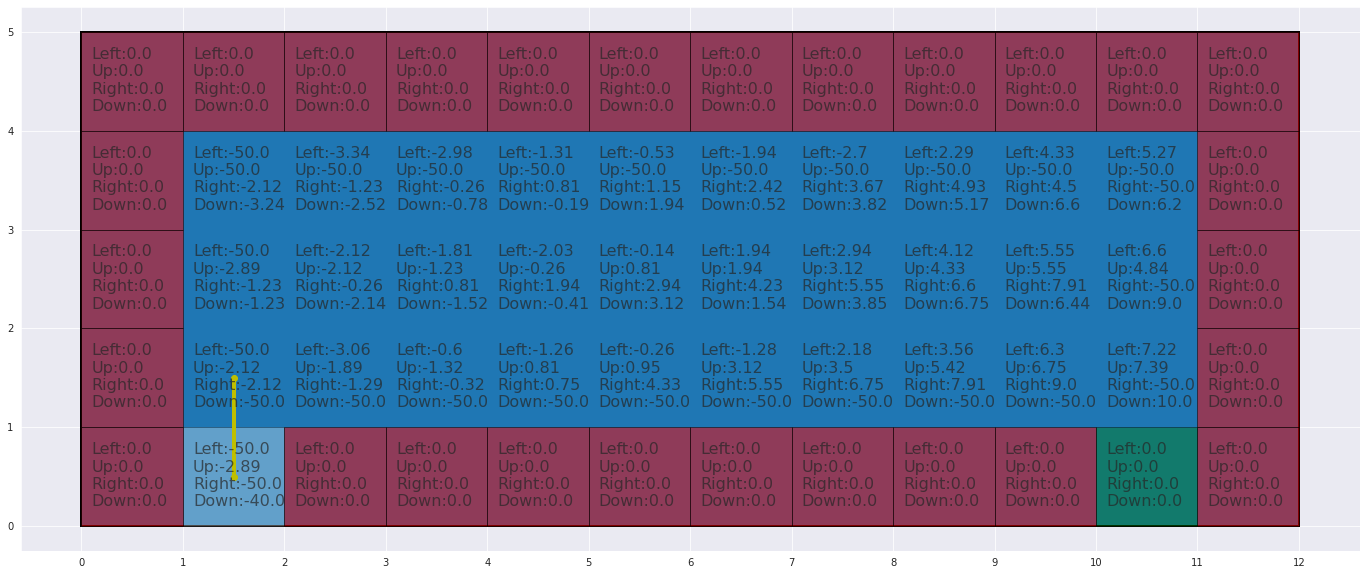

In [ ]:
# Обучаем агента на 200 играх, смотрим, как он обучается:
position = train(200)

### Тестируем обученный алгоритм

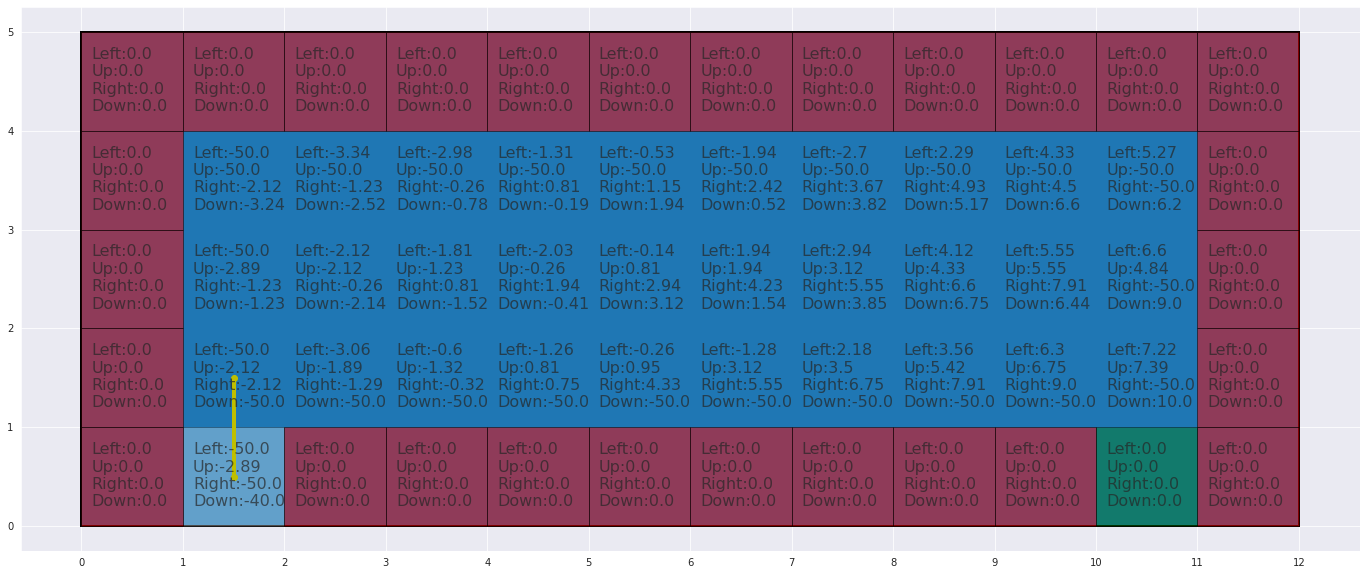

In [ ]:
# Тестируем результат (ставим нулевое значение параметру epsilon):

epsilon = 0
position = train(1)

**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1tIWj21EKDHdmLvlzVISYmrAYbSv1q7OF?usp=sharing)
2. Практический ноутбук 1
3. [Практический ноутбук 2](https://colab.research.google.com/drive/1ENgfK6-RmUlW5p9_J25wn-XXgh-2TJsw?usp=sharing)
